# [Whether a Parts Failure Will Occur](https://pathfinder.datarobot.com/notebook/predictions-fantasy-baseball?tab=overview)

OneNote2021 > DataRobot > Pathfinder 用例推廣 

In [ ]:
# LBB2 has not installed DataRobot so I carefully make this jupyternotebook to use the correct kernel (my Orange3 venv) and try pip install.
# Anticipating the installation can be done within this VS Code JupyterNotebook.
!pip install datarobot

# The above has two problems: 
#   catboost 0.26.1 requires graphviz, which is not installed.
#   catboost 0.26.1 requires plotly, which is not installed.
# Don't care for now, let's go on. Yes we can because import datarobot is ok. 

In [1]:
%run c:\Users\8304018\Documents\GitHub\examples-for-data-scientists\Playground\jupyter-extension-4-DataRobot.py

c:\Users\8304018\Documents\GitHub\examples-for-data-scientists\Playground\jupyter-extension-4-DataRobot.py
p e f o r t h    v1.28
source code http://github.com/hcchengithub/peforth
Type 'peforth.ok()' to enter forth interpreter, 'exit' to come back.



In [46]:
%matplotlib inline
from IPython.core.display import HTML
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

light_blue = "#598fd6"
grey_blue = "#5f728b"
orange = "#dd6b3d"

# Read in data

In [3]:
data_path = "https://s3.amazonaws.com/datarobot-use-case-datasets/maintenance_training.csv"
pathfinder_df = pd.read_csv(data_path, encoding = "ISO-8859-1")
display(pathfinder_df.head(100)) # Zepl's z.show() === display() 

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1
...,...,...,...,...,...,...,...
95,41,0,92.453609,92.495352,140.160091,TeamB,Provider2
96,12,0,112.047415,89.849594,81.100953,TeamB,Provider2
97,65,1,125.032692,101.163482,126.024077,TeamB,Provider3
98,80,1,96.008785,84.587554,95.287253,TeamA,Provider1


## Average Lifetime of Parts (Days)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider,broken_str
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4,Not Broken
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4,Broken
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1,Not Broken
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2,Broken
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1,Not Broken
...,...,...,...,...,...,...,...,...
907,88,1,88.589759,112.167556,99.861456,TeamB,Provider4,Broken
908,88,1,116.727075,110.871332,95.075631,TeamA,Provider4,Broken
909,22,0,104.026778,88.212873,83.221220,TeamB,Provider1,Not Broken
910,78,0,104.911649,104.257296,83.421491,TeamA,Provider4,Not Broken


,lifetime,broken,pressureInd,moistureInd,temperatureInd
broken_str,,,,,
Broken,78.307065,1.0,97.814086,99.376745,101.523164
Not Broken,39.551471,0.0,99.082933,99.557499,100.478428


<BarContainer object of 2 artists>

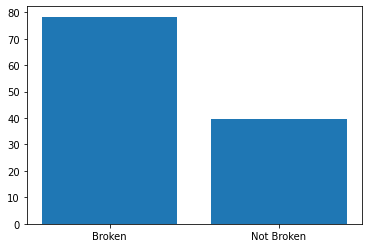

In [31]:
# 增加 feature column, 常幹的事。
pathfinder_df["broken_str"] = pathfinder_df["broken"].replace(0, "Not Broken").replace(1, "Broken")
display(pathfinder_df)

# 原文不清楚，咱把它推出來了！嘻嘻
lifetime_df = pathfinder_df.groupby('broken_str').mean()  # 發現 Pandas 有這樣的功能！ 

display(lifetime_df)
plt.bar(lifetime_df.index,lifetime_df['lifetime'])

## Broken Parts % by Provider

,provider,broken
0,Provider1,0.446903
1,Provider2,0.358025
2,Provider3,0.479452
3,Provider4,0.334821


<BarContainer object of 4 artists>

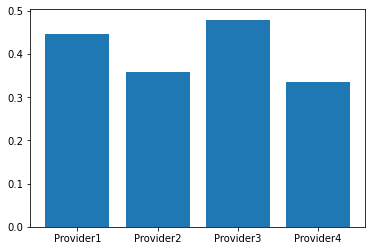

In [13]:
df1 = pathfinder_df.where(pathfinder_df['broken'] == 1).groupby('provider').agg({'broken': 'count'})
df2 = pathfinder_df.where(pathfinder_df['broken'] == 0).groupby('provider').agg({'broken': 'count'})

df_perc = (df1/(df2+df1))
df_perc = df_perc.reset_index()

display(df_perc)
plt.bar(df_perc['provider'],df_perc['broken'])

## Broken Parts % by Team

,team,broken
0,TeamA,0.369637
1,TeamB,0.425532
2,TeamC,0.414286


<BarContainer object of 3 artists>

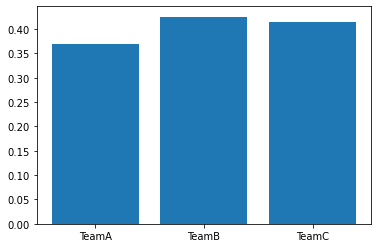

In [41]:
df1 = pathfinder_df.where(pathfinder_df['broken'] == 1).groupby('team').agg({'broken': 'count'})
df2 = pathfinder_df.where(pathfinder_df['broken'] == 0).groupby('team').agg({'broken': 'count'})

df_perc = (df1/(df2+df1))
df_perc = df_perc.reset_index()

display(df_perc)
plt.bar(df_perc['team'],df_perc['broken'])

# DataRobot Modeling

## Connect to DataRobot

In [43]:
dr.Client(token=peforth.execute('api_token').pop(), endpoint=peforth.execute('endpoint').pop())
# wall time 0.9s

## Create and Start DataRobot Project 
*login to DataRobot to see your project starting...this may take a few minutes

In [ ]:
# Uncomment and replace Project ID if project already exists in DataRobot
project = dr.Project.get("619f2f9641b6a2ba472a30a9") # 真咱建的 project ID！

In [44]:
# Create project and pass in data
# project = dr.Project.create(sourcedata = pathfinder_df,
#                             project_name = 'Predictive Maintenance')

In [45]:
# Set Project target to the appropriate feature (column name). We will use the LogLoss metric to measure performance and manually specify Autopilot to run on a subset of models
# project.set_target(target='broken',
#                   mode=dr.AUTOPILOT_MODE.QUICK, 
#                   worker_count='-1')

Project(Predictive Maintenance)

In [48]:

# Get the project metric (i.e LogLoss, RMSE, etc...)
metric = project.metric

# Get Project URL
project_url = project.get_leaderboard_ui_permalink()

# Display Project ID and Name
display(HTML('''<h3> Project Details</h3> 
                    <ul>
                        <li>Project URL: <a href="{project_url}" target="_blank">{project_url}</a></li>
                        <li>Project ID: {project_id}</li>
                        <li>Project Name: {project_name}</li> 
                    </ul>
    '''.format(project_url = project_url, project_id = project.id, project_name = project.project_name)))

## Pause notebook execution until training is complet

In [50]:
project.wait_for_autopilot(check_interval=30)

In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 2s)
In progress: 0, queued: 0 (waited: 3s)
In progress: 0, queued: 0 (waited: 4s)
In progress: 0, queued: 0 (waited: 6s)
In progress: 0, queued: 0 (waited: 8s)
In progress: 0, queued: 0 (waited: 12s)
In progress: 0, queued: 0 (waited: 19s)
In progress: 0, queued: 0 (waited: 33s)


# 筆記

## 意外學到了 Pandas DataFrame 高級功能
意外學到了 Pandas DataFrame 具有 Elasticsearch 一樣的 grouping、aggregation 等功能

    From:
    GitHub\examples-for-data-scientists\Playground\pathfinder examples\Whether a Parts Failure Will Occur\Whether a Parts Failure Will Occur.ipynb


In [ ]:
pathfinder_df

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider,broken_str
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4,Not Broken
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4,Broken
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1,Not Broken
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2,Broken
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1,Not Broken
...,...,...,...,...,...,...,...,...
907,88,1,88.589759,112.167556,99.861456,TeamB,Provider4,Broken
908,88,1,116.727075,110.871332,95.075631,TeamA,Provider4,Broken
909,22,0,104.026778,88.212873,83.221220,TeamB,Provider1,Not Broken
910,78,0,104.911649,104.257296,83.421491,TeamA,Provider4,Not Broken


In [ ]:
pathfinder_df.where(pathfinder_df['broken'] == 1)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider,broken_str
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,81.0,1.0,72.075938,103.065701,87.271062,TeamC,Provider4,Broken
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86.0,1.0,94.406461,108.493608,72.025374,TeamC,Provider2,Broken
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
907,88.0,1.0,88.589759,112.167556,99.861456,TeamB,Provider4,Broken
908,88.0,1.0,116.727075,110.871332,95.075631,TeamA,Provider4,Broken
909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pathfinder_df.where(pathfinder_df['broken'] == 1).groupby('provider')

In [ ]:
pathfinder_df.where(pathfinder_df['broken'] == 1).groupby('provider').agg({'broken': 'count'})

,broken
provider,
Provider1,101
Provider2,87
Provider3,105
Provider4,75


In [ ]:
display(pathfinder_df.where(pathfinder_df['broken'] == 1).groupby('provider').mean())

,lifetime,broken,pressureInd,moistureInd,temperatureInd
provider,,,,,
Provider1,78.009901,1.0,98.143345,99.794591,102.033052
Provider2,90.505747,1.0,99.868258,98.274949,102.814799
Provider3,63.628571,1.0,96.966253,98.941432,101.988422
Provider4,85.106667,1.0,96.174813,100.701566,98.686855
